In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re

from gensim.models import Word2Vec # Word2Vec module
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric, stem_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('latest_ticket_data.csv')

In [ ]:
LE = LabelEncoder()
df['label'] = LE.fit_transform(df['Category'])

In [ ]:
# Generate samples that contains K samples of each class
def gen_sample(df, sample_size, num_classes):

    df_1 = df[(df["label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["label"] == np.unique(df_1['label'])[0]].sample(sample_size)

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["label"] == np.unique(df_1['label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]

    return train, test

In [ ]:
train_df , rest_df  = gen_sample(df, 200, 5)

In [ ]:
test_df, submission_df = gen_sample(rest_df, 200, 5)

In [ ]:
# Stemmer object
porter = PorterStemmer()
wnl = WordNetLemmatizer()

class DataPreprocess:

    def __init__(self):
        self.filters = [strip_tags,
                       strip_numeric,
                       strip_punctuation,
                       lambda x: x.lower(),
                       lambda x: re.sub(r'\s+\w{1}\s+', '', x),
                       remove_stopwords]
    def __call__(self, doc):
        clean_words = self.__apply_filter(doc)
        return clean_words

    def __apply_filter(self, doc):
        try:
            cleanse_words = set(preprocess_string(doc, self.filters))
#             filtered_words = set(wnl.lemmatize(w) if w.endswith('e') or w.endswith('y') else porter.stem(w) for w in cleanse_words)
            return ' '.join(cleanse_words)
        except TypeError as te:
            raise(TypeError("Not a valid data {}".format(te)))

In [ ]:
train_df['train_or_test'] = 0
test_df['train_or_test'] = 1

feature_col = ['Description', 'label', 'train_or_test']

In [ ]:
combined_set = pd.concat([train_df[feature_col], test_df[feature_col]])

In [ ]:
combined_set

,Description,label,train_or_test
137,leaver form leave date location hello leaver f...,0,0
148,please action reports please update he sick le...,0,0
434,write change hello please log best regards sen...,0,0
532,holiday query myself colleague querying databa...,0,0
78,re update has assigned queue hello please chan...,0,0
...,...,...,...
1094,thursday pm visitor cards review hi please eac...,4,1
1078,thursday pm card card si ca,4,1
1160,pm card dear please reactivate card locations ...,4,1
840,hi please approve floor thanks,4,1


In [ ]:
combined_set['Processed'] = combined_set['Description'].apply(DataPreprocess())

In [ ]:
train_set = combined_set.loc[combined_set['train_or_test'] == 0]
test_set = combined_set.loc[combined_set['train_or_test'] == 1]
# Drop key reference column
train_set = train_set.drop('train_or_test', axis=1)
test_set = test_set.drop('train_or_test', axis=1)

In [ ]:
train_data = train_set['Processed']
test_data = test_set['Processed']

y = train_set.label

X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.3, random_state=42)

In [ ]:
def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()

    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_

    return y_train_enc, labels


def word_embedding(train, test, max_features, max_len=200):
    try:
        # Keras Tokenizer class object
        tokenizer = text.Tokenizer(num_words=max_features)
        tokenizer.fit_on_texts(train)

        train_data = tokenizer.texts_to_sequences(train)
        test_data = tokenizer.texts_to_sequences(test)

        # Get the max_len
        vocab_size = len(tokenizer.word_index) + 1

        # Padd the sequence based on the max-length
        x_train = sequence.pad_sequences(train_data, maxlen=max_len, padding='post')
        x_test = sequence.pad_sequences(test_data, maxlen=max_len, padding='post')
        # Return train, test and vocab size
        return tokenizer, x_train, x_test, vocab_size
    except ValueError as ve:
        raise(ValueError("Error in word embedding {}".format(ve)))

In [ ]:
max_features = 6000
max_len = 200

tokenizer, x_pad_train, x_pad_valid, vocab_size = word_embedding(X_train, X_valid, max_features)

In [ ]:
x_pad_train.shape
print("Vocab size: {}".format(vocab_size))

Vocab size: 2460


In [ ]:
def build_rnn(vocab_size,output_dim, max_len):
    # Building RNN model
    model = Sequential([
        keras.layers.Embedding(vocab_size,200,
                              input_length=max_len),
        keras.layers.BatchNormalization(),
        keras.layers.Bidirectional(keras.layers.LSTM(256,return_sequences=True)),
        keras.layers.GlobalMaxPool1D(), # Remove flatten layer
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(output_dim, activation='sigmoid')
    ])

    return model

In [ ]:
rnn_model = build_rnn(vocab_size, 1, max_len)

# Summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          492000    
                                                                 
 batch_normalization_1 (Bat  (None, 200, 200)          800       
 chNormalization)                                                
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 512)          935936    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                      

In [ ]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = rnn_model.fit(x_pad_train,
                        y_train,
                        batch_size=256,
                       epochs=7,
                       verbose=1,
                       validation_split=0.2)

Epoch 1/7
3/3 [==============================] - 31s 7s/step - loss: -0.7670 - acc: 0.1750 - val_loss: 0.4793 - val_acc: 0.2143
Epoch 2/7
3/3 [==============================] - 22s 7s/step - loss: -7.1143 - acc: 0.1750 - val_loss: -0.3415 - val_acc: 0.2143
Epoch 3/7
3/3 [==============================] - 22s 7s/step - loss: -20.9632 - acc: 0.1768 - val_loss: -3.4379 - val_acc: 0.2143
Epoch 4/7
3/3 [==============================] - 22s 7s/step - loss: -45.5710 - acc: 0.1768 - val_loss: -13.0870 - val_acc: 0.2143
Epoch 5/7
3/3 [==============================] - 20s 6s/step - loss: -91.9633 - acc: 0.1768 - val_loss: -35.2944 - val_acc: 0.2143
Epoch 6/7
3/3 [==============================] - 20s 6s/step - loss: -161.1704 - acc: 0.1768 - val_loss: -79.3787 - val_acc: 0.2143
Epoch 7/7
3/3 [==============================] - 21s 6s/step - loss: -266.3431 - acc: 0.1768 - val_loss: -136.0892 - val_acc: 0.2143


In [ ]:
score = rnn_model.evaluate(x_pad_valid, y_valid, verbose=1)

print("Loss:%.3f Accuracy: %.3f" % (score[0], score[1]))

10/10 [==============================] - 4s 391ms/step - loss: -155.0823 - acc: 0.2367
Loss:-155.082 Accuracy: 0.237


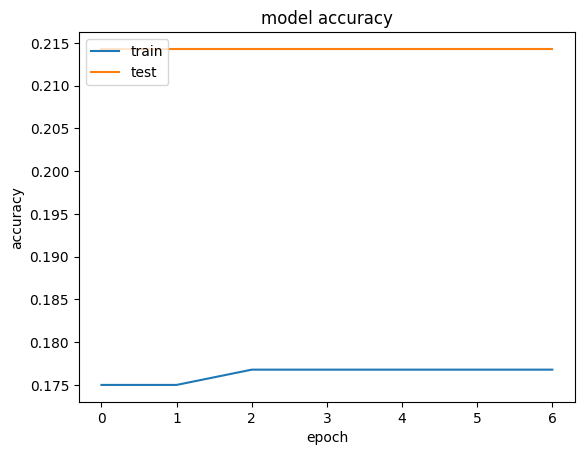

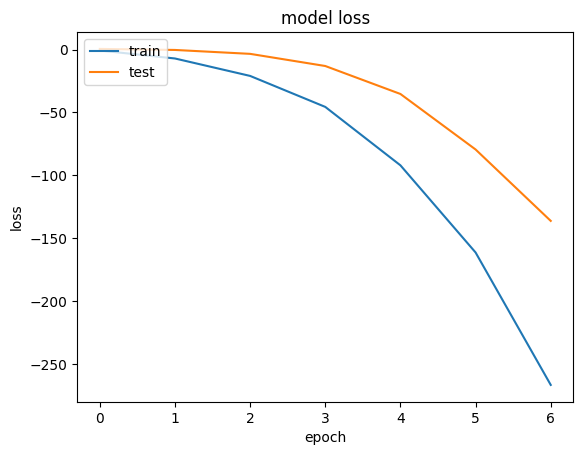

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
len(test_data)

1000

In [ ]:
# tokenizer = text.Tokenizer(num_words=5000)
tokenizer.fit_on_sequences(test_data)

X_test = tokenizer.texts_to_sequences(test_data)
x_pad_test = sequence.pad_sequences(X_test, maxlen=max_len, padding='post')

In [ ]:
x_pad_test

array([[  56,    1,  378, ...,    0,    0,    0],
       [ 101, 1196,   48, ...,    0,    0,    0],
       [   4,   29,  948, ...,    0,    0,    0],
       ...,
       [ 478,    9,   10, ...,    0,    0,    0],
       [   6,    1,  278, ...,    0,    0,    0],
       [  24, 1962,    1, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_preds = rnn_model.predict(x_pad_test)

32/32 [==============================] - 16s 489ms/step


In [ ]:
for arr in y_preds:
    for i in range(len(arr)):
        if arr[i]>0.5:
            arr[i] = 1
        else:
            arr[i] = 0

In [ ]:
y_preds = y_preds.astype('int32')

In [ ]:
y_preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [ ]:
pred_df = pd.DataFrame(y_preds)